In [1]:
import numpy as np
import pandas as pd
import re
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, auc, roc_curve
from lxml import etree
from itertools import groupby
import glob
import math
import itertools
from sklearn.metrics import *
import matplotlib.pyplot as plt

def load_xml_files(directory):
    """Load and parse XML files into a single DataFrame."""
    xml_list = glob.glob(f"{directory}/*.xml")
    parser = etree.XMLParser(recover=True)
    dfs = []

    for ii in xml_list:
        with open(ii, 'rb') as file:
            xml_data = file.read()
            root = etree.fromstring(xml_data, parser=parser)
            all_records = []
            for i, child in enumerate(root):
                record = {}
                for subchild in child:
                    record[subchild.tag] = subchild.text
                all_records.append(record)
            dfs.append(pd.DataFrame(all_records))
    
    data = pd.concat(dfs, ignore_index=True)
    return data.drop_duplicates().sort_values("startDateTime")

def preprocess_data(data):
    """Preprocess the data for sequence generation."""
    data['totalBytes'] = data['totalSourceBytes'].astype(float) + data['totalDestinationBytes'].astype(float)
    data['seqId'] = data['lowIP'] + '_' + data['highIP']  + '_' + data['startDateTime'].str[:13]
    data['protoBytes'] = data[['protocolName','totalBytes']].apply(
        lambda x: str(x[0])[0] + str(int(np.log2(x[1] + 1.0))), axis=1)
    return data

def create_sequences(data, seq_len=10):
    """Create input and output sequences from data."""
    key = data.groupby('seqId')[['Tag', 'protoBytes']].agg({
        "Tag": lambda x: "%s" % ','.join([a for a in x]),
        "protoBytes": lambda x: "%s" % ','.join([str(a) for a in x])
    })

    attacks = [a.split(",") for a in key['Tag'].tolist()]
    sequences = [a.split(",") for a in key['protoBytes'].tolist()]
    unique_tokens = list(set([a for b in sequences for a in b]))

    le = LabelEncoder()
    unique_tokens = list(set([a for b in sequences for a in b]))
    le.fit(unique_tokens)
    sequences = [le.transform(s).tolist() for s in sequences]
    sequences = [[b+1 for b in a] for a in sequences]

    sequence_attack = zip(attacks, sequences)

    seq_x = []
    seq_y = []
    seq_index = []
    seq_attack = []
    for si, (sa, ss) in enumerate(sequence_attack):
        prepend = [0.] * seq_len
        seq = prepend + ss
        seqa = prepend + sa
        for ii in range(seq_len, len(seq)):
            subseq = seq[(ii-seq_len):ii]
            seq_x.append(subseq)
            seq_y.append(seq[ii])
            seq_index.append(si)
            seq_attack.append(seqa[ii])

    return np.array(seq_x), np.array(seq_y), seq_index, seq_attack, unique_tokens

# Configuration and Initialization
data_directory = r"D:\AML\ISCX dataset\original"
print("Loading data...")
data = load_xml_files(data_directory)
print("Preprocessing data...")
data = preprocess_data(data)
print("Creating sequences...")
seq_x, seq_y, seq_index, seq_attack, unique_tokens = create_sequences(data)
ohe = OneHotEncoder(sparse=False)
ohe_y = ohe.fit_transform(np.array(seq_y).reshape(-1, 1))
X = np.array(seq_x)
print("Ready to go!")

Loading data...
De-dup Flows: 1889172


C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['lowIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] <= x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['highIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

Ready to Go!


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time

# Define the Dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        # Assuming y is already class indices here
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Changed to long dtype
        return x, y

X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(seq_y), test_size=0.2, random_state=42)
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)  # Shuffle=False for testing


In [3]:
import torch
import torch.nn as nn

# Define the CLSTM Model
class CLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(hidden_dim*2, 50)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        
        # Reshape for Conv1D input (batch_size, channels, seq_length)
        embedded = embedded.permute(0, 2, 1)
        
        # Apply convolutional layers with activation
        conv_out = torch.relu(self.conv1(embedded))
        conv_out = torch.relu(self.conv2(conv_out))
        
        # Reshape back to (batch_size, seq_length, channels)
        conv_out = conv_out.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm1(conv_out)
        lstm_out = self.dropout1(lstm_out)
        
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])  # Get the output of the last time step
        
        dense_out = torch.relu(self.fc1(lstm_out))
        dense_out = self.dropout3(dense_out)
        out = self.fc2(dense_out)  # No softmax here
        return out

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss, and optimizer
vocab_size = len(unique_tokens) + 1  # Account for padding index
model = CLSTM(vocab_size, 100, 50, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [4]:
print(model)

CLSTM(
  (embedding): Embedding(54, 100, padding_idx=0)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm1): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=54, bias=True)
)


In [ ]:
import time
import matplotlib.pyplot as plt
import torch

# Lists to track loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 15
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

    # Average training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

    # Average test loss and accuracy
    test_epoch_loss = test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_predictions * 100
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_accuracy)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

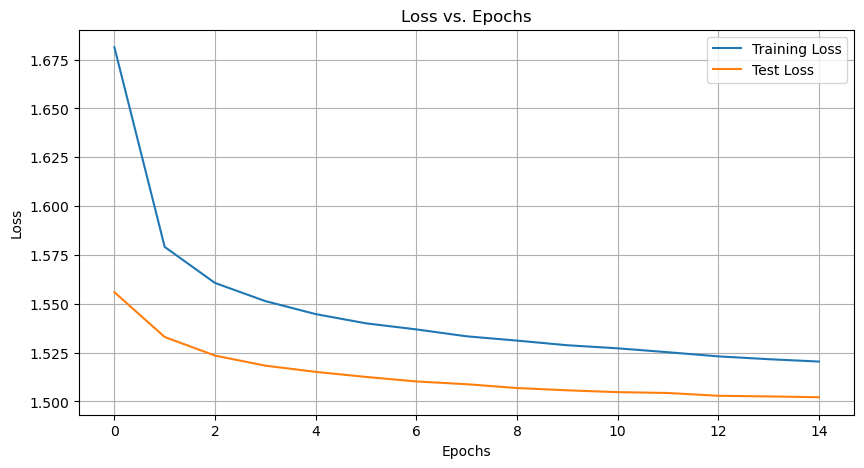

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

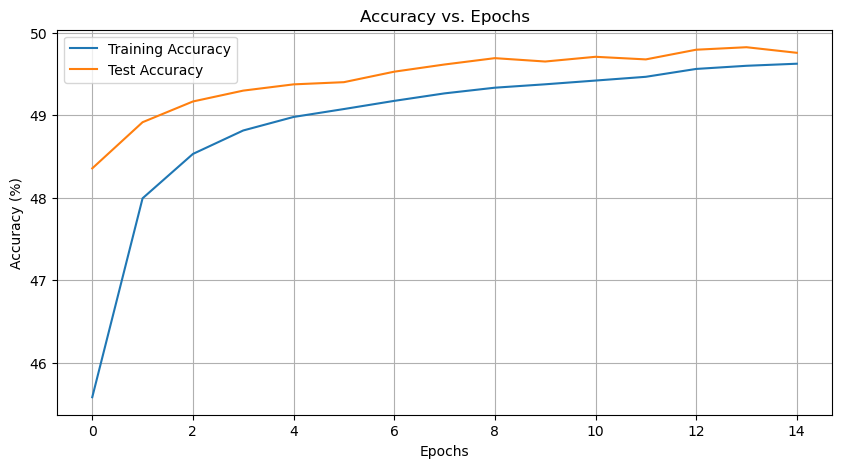

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Convert X to a PyTorch DataLoader
# First, ensure X is a tensor of the correct type. Assuming X is a numpy array of indices:
X_tensor = torch.tensor(X, dtype=torch.long)  # Convert X to a long tensor

# If X and seq_y are your dataset, and you're looking to make predictions for the entire set,
# ensure they are correctly shaped and typed
# For the DataLoader, you only need the inputs since you're making predictions
data_loader = DataLoader(TensorDataset(X_tensor), batch_size=512)

predictions = []
model = model.to('cpu')
with torch.no_grad():
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        predictions.extend(outputs.detach().numpy())


predictions = np.array(predictions)

# Apply softmax if your model's output needs it to represent probabilities
predictions = torch.softmax(torch.tensor(predictions), dim=1).numpy()


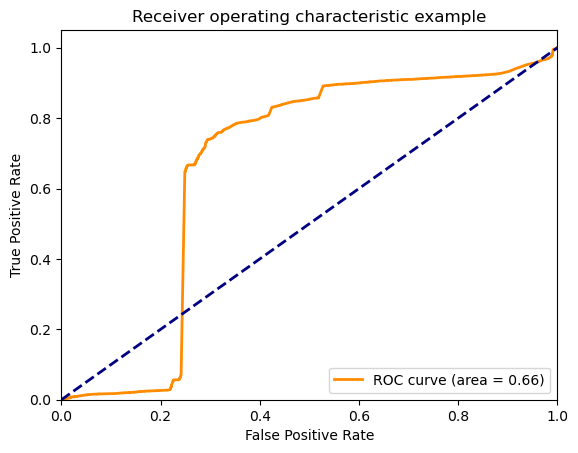

In [22]:
test_index = range(0,len(predictions))
indexed_preds = zip(np.asarray(seq_index)[np.asarray(test_index)], predictions, ohe_y[np.asarray(test_index)], np.asarray(seq_attack)[np.asarray(test_index)])
logloss_list = []
epsilon = 1e-10
for (ii, pp, yy, aa) in indexed_preds:
    ll = -math.log(pp[np.argmax(yy)] + epsilon)
    logloss_list.append(ll)

fpr, tpr, thresholds = roc_curve(np.asarray(seq_attack)[np.asarray(test_index)],logloss_list, pos_label="Attack")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

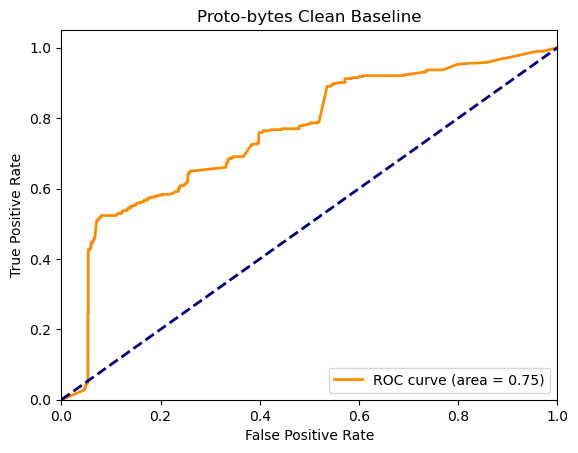

In [110]:
# aggregated roc in a dyad
# The observed improvement in ROC performance with aggregated data likely reflects a combination of more meaningful data representation, reduction
# in noise, and enhanced focus on contextually significant patterns. This approach is particularly effective in domains like network security, where attacks are context-sensitive and can span multiple related events.
# When presenting or considering these results, it's important to clearly
# communicate the rationale behind using aggregated metrics, as it shapes the interpretation of the model's effectiveness in real-world scenarios.
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proto-bytes Clean Baseline')
plt.legend(loc="lower right")
#plt.savefig("graphics/protobytes_dirty.pdf",format="pdf")
plt.show()

In [30]:
# aggregated roc in a dyad
# The observed improvement in ROC performance with aggregated data likely reflects a combination of more meaningful data representation, reduction
# in noise, and enhanced focus on contextually significant patterns. This approach is particularly effective in domains like network security, where attacks are context-sensitive and can span multiple related events.
# When presenting or considering these results, it's important to clearly
# communicate the rationale behind using aggregated metrics, as it shapes the interpretation of the model's effectiveness in real-world scenarios.
#! Find the true last token in the window
true_labels = np.argmax(ohe_y, 1)

#! Given the predictions and true labels, we can now aggregate the results
prob = [predictions[i, true_labels[i]] for i in range(len(ohe_y))]
agg_list = zip(seq_index, prob, seq_attack)
dictionary = {}
for (ii, pp, aa) in agg_list:
    current_value = dictionary.get(str(ii), ([],[]))
    dictionary[str(ii)] = (current_value[0] + [pp], current_value[1] + [aa])

#! Predict dyad hour data attack or not
agg_pred = []
agg_true = []

for key, val in dictionary.items():
    bad = np.mean([v=="Attack" for v in val[1]]) > 0
    score = np.min(val[0]) < 0.001
    agg_true.append(int(bad))
    agg_pred.append(int(score))

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Assume the required data has been processed up to agg_pred and agg_true as shown above

# Calculating metrics
precision = precision_score(agg_true, agg_pred)
recall = recall_score(agg_true, agg_pred)
f1 = f1_score(agg_true, agg_pred)
accuracy = accuracy_score(agg_true, agg_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


# print("Prediction of Attack: ", agg_pred)
# print("True Label of Attack ", agg_true)  

Precision: 0.76
Recall: 0.71
F1 Score: 0.73
Accuracy: 0.82
